In [1]:
import numpy as np
import pandas as pd

from statsmodels.tsa.stattools import coint, adfuller
from statsmodels.tools.tools import add_constant
from statsmodels.regression.linear_model import OLS

import yfinance as yf

import matplotlib.pyplot as plt

In [6]:
Tickers = ['BTC-USD', 'ETH-USD', 'BNB-USD', 'ADA-USD', 'DOT-USD', 'MATIC-USD', 'DOGE-USD', 'LTC-USD', 'SOL-USD',  'XRP-USD']

In [14]:
data = yf.download(Tickers, start="2024-01-01", end="2024-02-01",interval="1h")
df = data["Adj Close"].dropna(how="all")

[*********************100%***********************]  10 of 10 completed


In [15]:
df.isnull().any()

ADA-USD      False
BNB-USD      False
BTC-USD      False
DOGE-USD     False
DOT-USD      False
ETH-USD      False
LTC-USD      False
MATIC-USD    False
SOL-USD      False
XRP-USD      False
dtype: bool

In [16]:
df.head()

,ADA-USD,BNB-USD,BTC-USD,DOGE-USD,DOT-USD,ETH-USD,LTC-USD,MATIC-USD,SOL-USD,XRP-USD
Datetime,,,,,,,,,,
2024-01-01 00:00:00+00:00,0.597694,314.704285,42477.253906,0.089899,8.261270,2295.486328,73.057617,0.982807,102.134453,0.616168
2024-01-01 01:00:00+00:00,0.602531,315.451874,42622.898438,0.090176,8.303284,2303.165527,73.300972,0.990644,104.180428,0.618817
2024-01-01 02:00:00+00:00,0.599645,311.947510,42576.601562,0.089917,8.256529,2293.860596,73.250809,0.983992,103.970222,0.616137
2024-01-01 03:00:00+00:00,0.596257,309.703491,42320.730469,0.089362,8.151831,2273.409424,72.710899,0.969545,102.887131,0.613529
2024-01-01 04:00:00+00:00,0.594527,309.440277,42387.164062,0.089096,8.131610,2278.694092,72.488388,0.964055,102.431519,0.611914


In [19]:
def check_stationarity(df):
    results = []
    for ticker, prices in df.items():
        results.append([ticker, adfuller(prices, regression='ct')[1]])
    return pd.DataFrame(results, columns=['ticker', 'adf']).sort_values('adf')

In [20]:
check_stationarity(df)

,ticker,adf
3,DOGE-USD,0.076750
1,BNB-USD,0.165925
9,XRP-USD,0.271630
0,ADA-USD,0.313577
7,MATIC-USD,0.343133
6,LTC-USD,0.366325
2,BTC-USD,0.371298
4,DOT-USD,0.381264
8,SOL-USD,0.393103
5,ETH-USD,0.822785


In [17]:
def cointegration_checker(crypto_dataframe):
    cointegrated_pairs = []
    
    k = crypto_dataframe.shape[1]
    p_values = np.ones( (k, k) )   
    
    keys = crypto_dataframe.keys()
    
    
    for i in range(k):
        for j in range(i+1, k):
            
            Asset_1 = crypto_dataframe[keys[i]]
            Asset_2 = crypto_dataframe[keys[j]]
            
            #iterating through the df and testing cointegration for all pairs of tickers
            Coint_Test = coint(Asset_1, Asset_2)
            
            pvalue = Coint_Test[1]
            #  p-values 
            p_values[i, j] = pvalue
            #p value matrix 
            if pvalue < 0.02:
                cointegrated_pairs.append((keys[i], keys[j]))
                
    return p_values, cointegrated_pairs

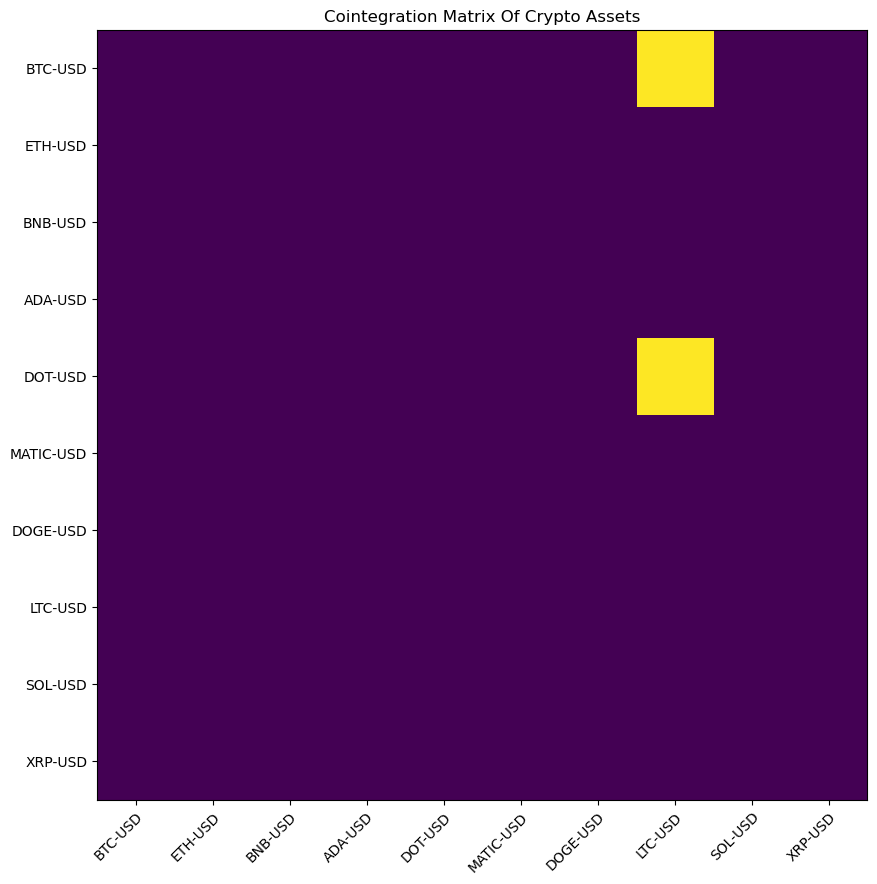

[('ADA-USD', 'MATIC-USD'), ('DOT-USD', 'MATIC-USD')]


In [18]:
pvalues, pairs = cointegration_checker(df)
fig, ax = plt.subplots(figsize=(25, 10))
im = ax.imshow(pvalues <= .02)

ax.set_xticks(np.arange(len(Tickers)))
ax.set_yticks(np.arange(len(Tickers)))

ax.set_xticklabels(Tickers)
ax.set_yticklabels(Tickers)
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")
ax.set_title("Cointegration Matrix Of Crypto Assets")
plt.show()
print(pairs) 

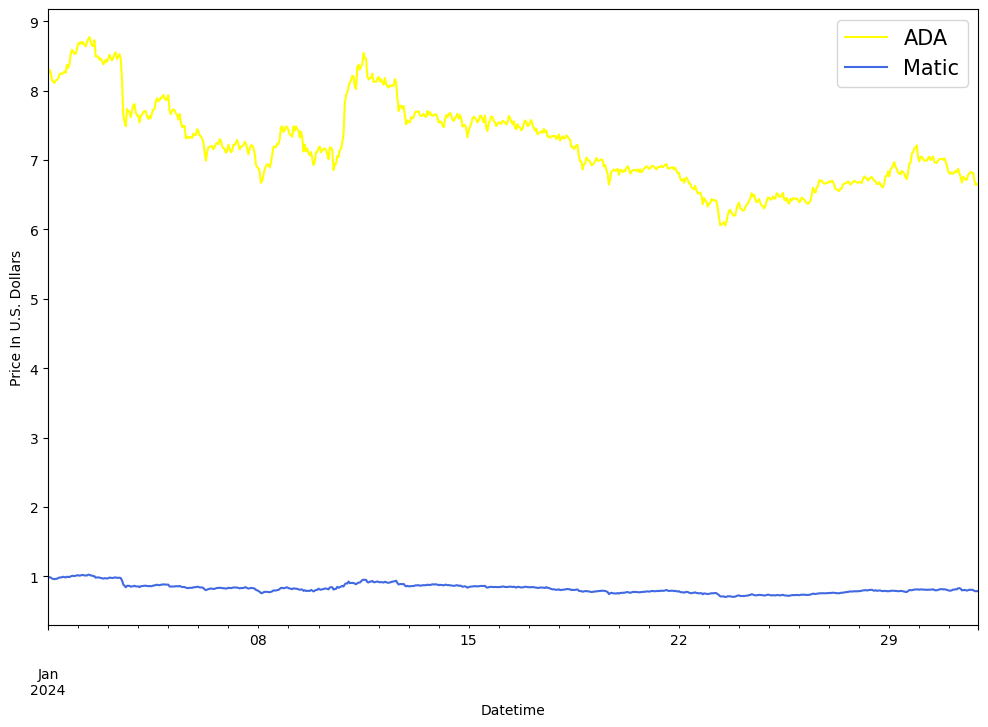

In [69]:
plt.figure(figsize=(12,8))
df['DOT-USD'].plot(color = 'yellow')
df['MATIC-USD'].plot(color = 'royalblue')
plt.legend(['ADA', 'Matic'], prop={'size': 15})
plt.ylabel('Price In U.S. Dollars')
plt.show()

In [70]:
placeholder, pvalue, placeholder2 = coint(df['DOT-USD'][0:252], df['MATIC-USD'][0:252])
print("The pvalue of the augmented Engle-Granger is", round(pvalue,5))

The pvalue of the augmented Engle-Granger is 0.01441


In [71]:
Asset_1 = df['MATIC-USD']
Asset_2 =  df['DOT-USD']

In [72]:
Asset_1  = add_constant(Asset_1)
results = OLS(Asset_2, Asset_1).fit()

coef = results.params['MATIC-USD']
Asset_1 = Asset_1['MATIC-USD']

spread = Asset_2 - (coef * Asset_1)

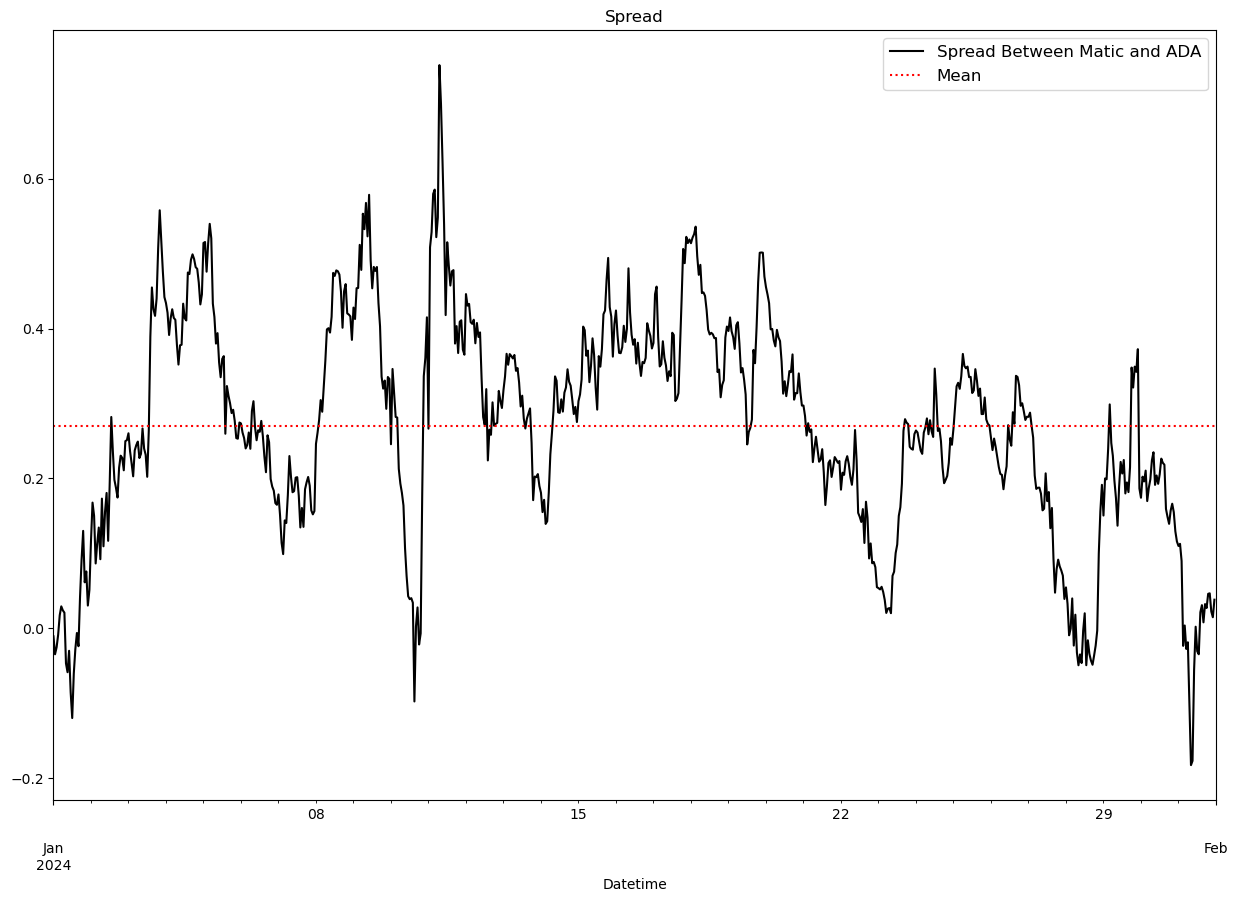

In [73]:
spread.plot(figsize=(15,10), color = 'black')
plt.xlim("2024-01-01", '2024-02-01') 
plt.axhline(spread.mean(), color='red', linestyle=':')
plt.legend(['Spread Between Matic and ADA', 'Mean'], prop={'size': 12});
plt.title("Spread")
plt.show()

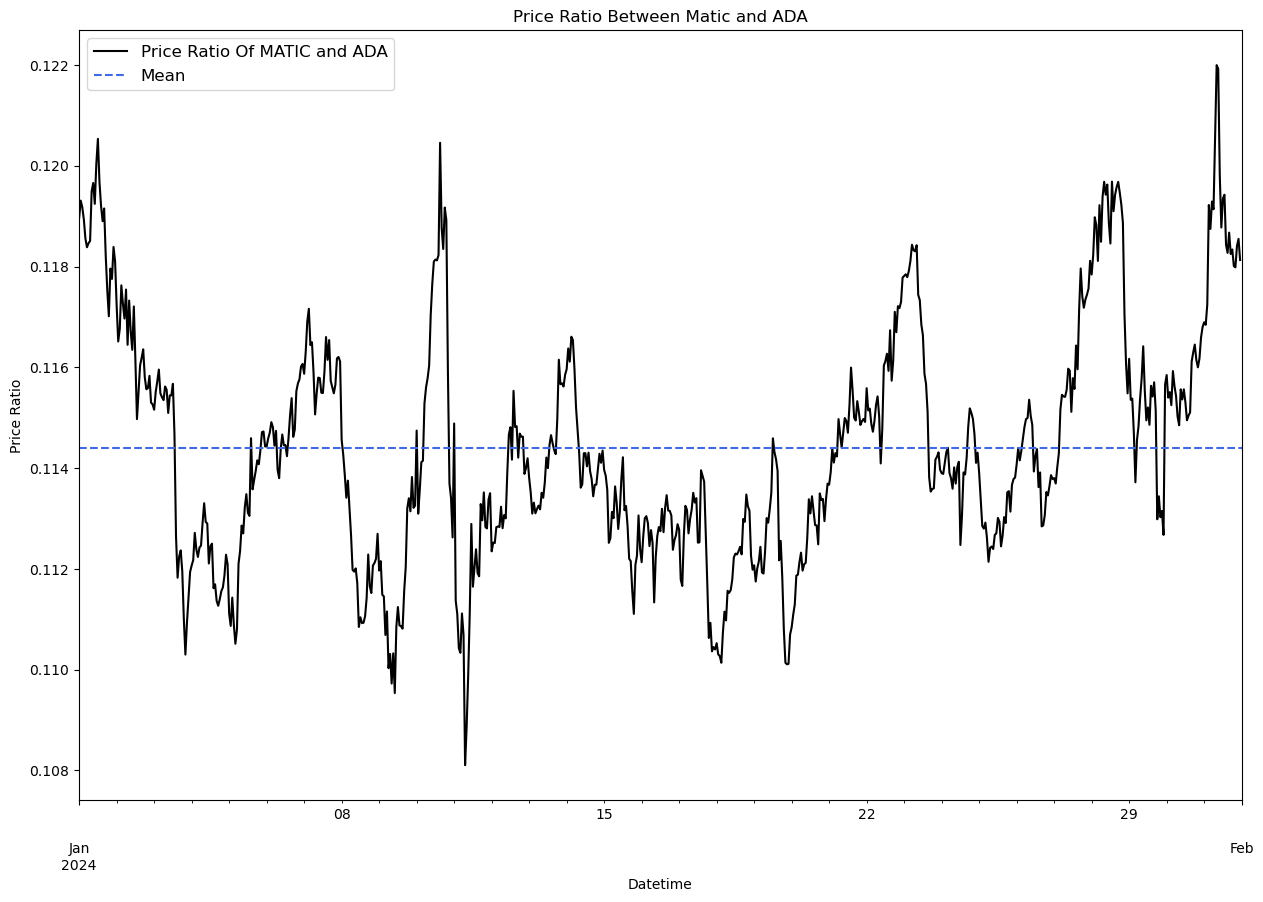

In [74]:
price_ratio = Asset_1/Asset_2
price_ratio.plot(figsize=(15,10), color = 'black')
plt.axhline(price_ratio.mean(), color='royalblue', linestyle='dashed')
plt.xlim('2024-01-01', '2024-02-01')
plt.legend(['Price Ratio Of MATIC and ADA', 'Mean'], prop={'size': 12});
plt.title("Price Ratio Between Matic and ADA")
plt.ylabel('Price Ratio')
plt.show()

In [75]:
price_ratio_pvalue = round(adfuller(price_ratio)[1],5)
spread_pvalue = round(adfuller(spread)[1],5)

(price_ratio_pvalue, spread_pvalue)

(0.0005, 0.00053)

In [76]:
def zscore(series):
    return (series - series.mean()) / np.std(series)

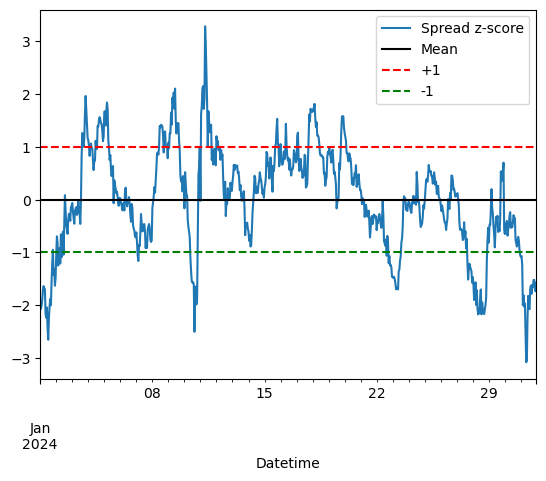

In [77]:
zscore(spread).plot()
plt.axhline(zscore(spread).mean(), color='black')
plt.axhline(1.0, color='red', linestyle='--')
plt.axhline(-1.0, color='green', linestyle='--')
plt.legend(['Spread z-score', 'Mean', '+1', '-1']);

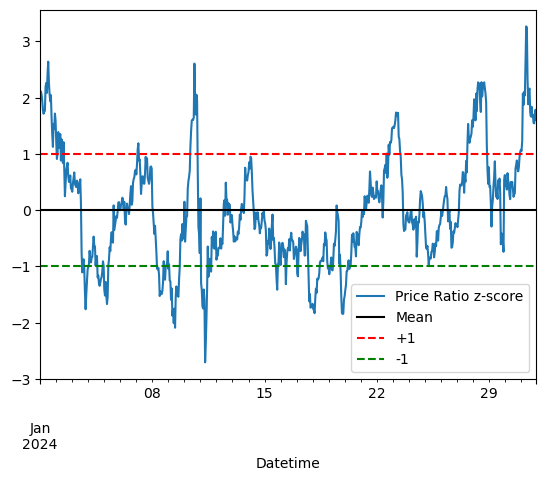

In [78]:
zscore(price_ratio).plot()
plt.axhline(zscore(spread).mean(), color='black')
plt.axhline(1.0, color='red', linestyle='--')
plt.axhline(-1.0, color='green', linestyle='--')
plt.legend(['Price Ratio z-score', 'Mean', '+1', '-1']);

Trading the spread

In [79]:
#price_ratio = Asset_1/Asset_2

spread_20D_MAVG = spread.rolling(window=20).mean() 
spread_60D_MAVG = spread.rolling(window=60).mean() 

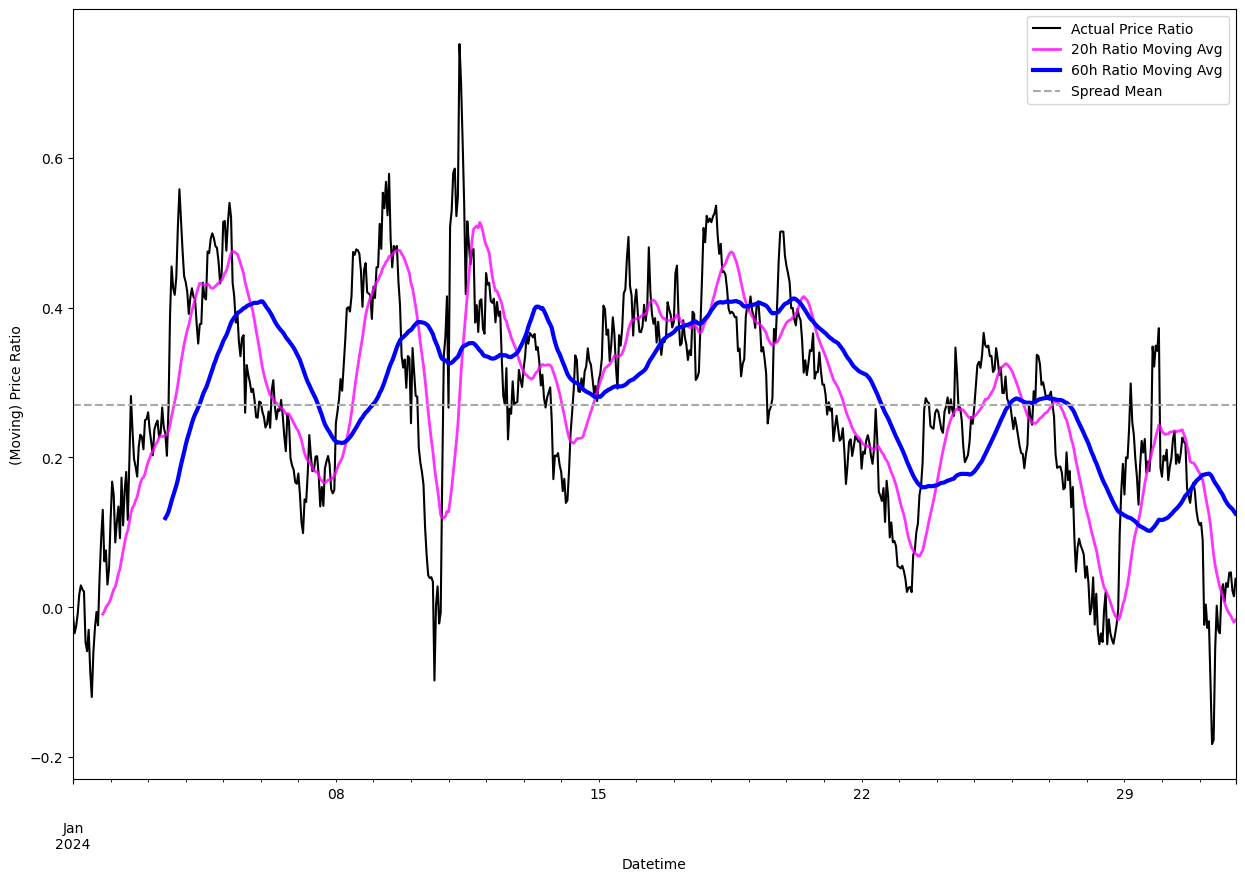

In [80]:
plt.figure(figsize=(15, 10))
spread.plot(color = 'black')
spread_20D_MAVG.plot(color = 'magenta', linewidth=2, alpha = .8)
spread_60D_MAVG.plot(color = 'b', linewidth=3)
plt.axhline(spread.mean(), color = 'darkgrey', linestyle = 'dashed' )
plt.legend(['Actual Price Ratio', '20h Ratio Moving Avg', '60h Ratio Moving Avg', 'Spread Mean'])
plt.ylabel('(Moving) Price Ratio')
plt.show()

<AxesSubplot:xlabel='Datetime'>

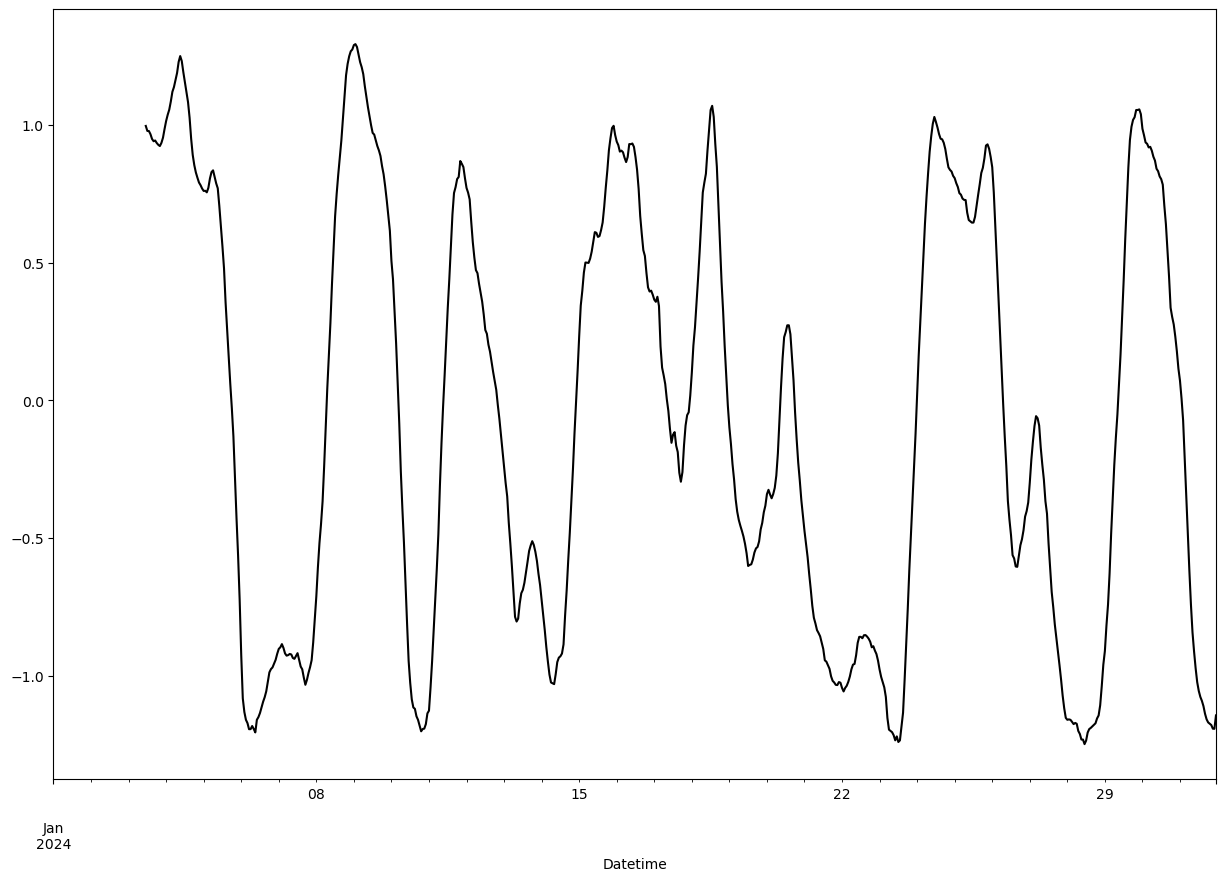

In [81]:
STD_60 = spread.rolling(window=60).std()
Rolling_Z_Score = ((spread_20D_MAVG - spread_60D_MAVG)/STD_60)
Rolling_Z_Score.plot(figsize=(15,10), color = 'black')

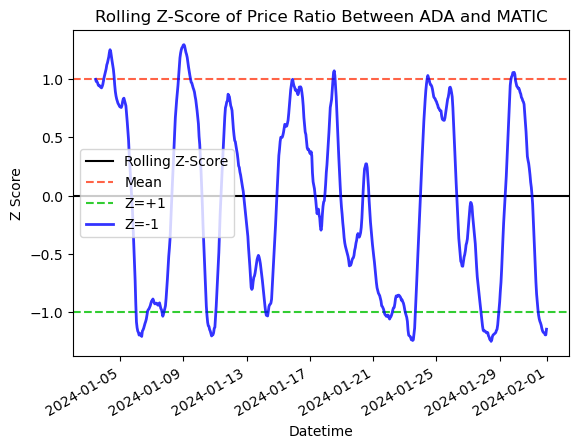

In [82]:
plt.axhline(0, color='black')
plt.axhline(1, color='tomato', linestyle='dashed')
plt.axhline(-1, color='limegreen', linestyle='dashed')
Rolling_Z_Score.plot(color = 'BLUE', linewidth=2, alpha = .8)
plt.legend(['Rolling Z-Score', 'Mean', 'Z=+1', 'Z=-1'])
plt.title("Rolling Z-Score of Price Ratio Between ADA and MATIC")
plt.ylabel('Z Score')
plt.show()

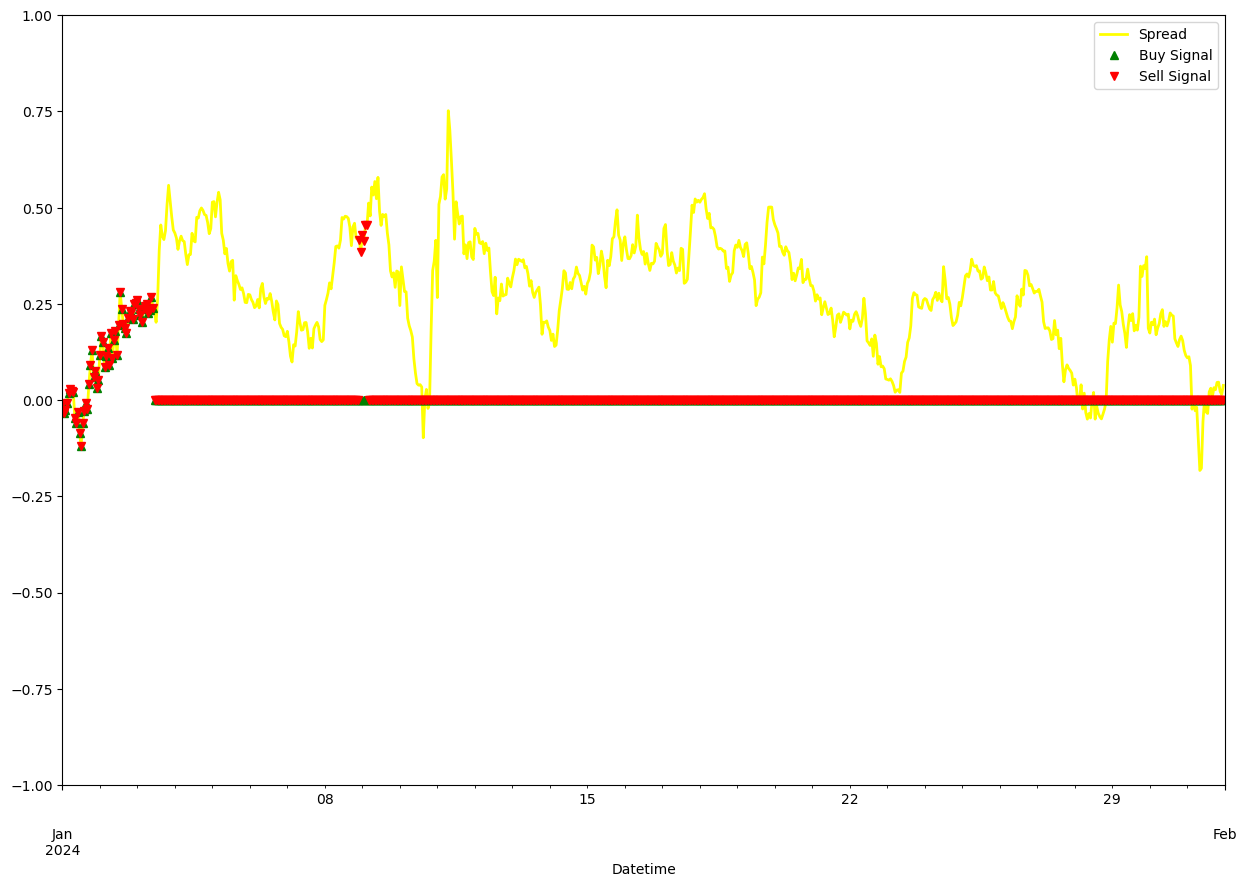

In [86]:
spread.plot(figsize=(15,10), color = 'yellow', linewidth = 2)
buy  = spread.copy()
sell = spread.copy()


buy[Rolling_Z_Score > -1.25] = 0
buy.plot(color='g', linestyle='None', marker='^')


sell[Rolling_Z_Score < 1.25] = 0
sell.plot(color='r', linestyle='None', marker='v')


plt.axis(('2024-01-01', '2024-02-01',-1,1))

plt.legend(['Spread', 'Buy Signal', 'Sell Signal'])
plt.show()

Trading the ratio

In [87]:
PR_20D_MAVG = price_ratio.rolling(window=20).mean() 
PR_60D_MAVG = price_ratio.rolling(window=60).mean() 

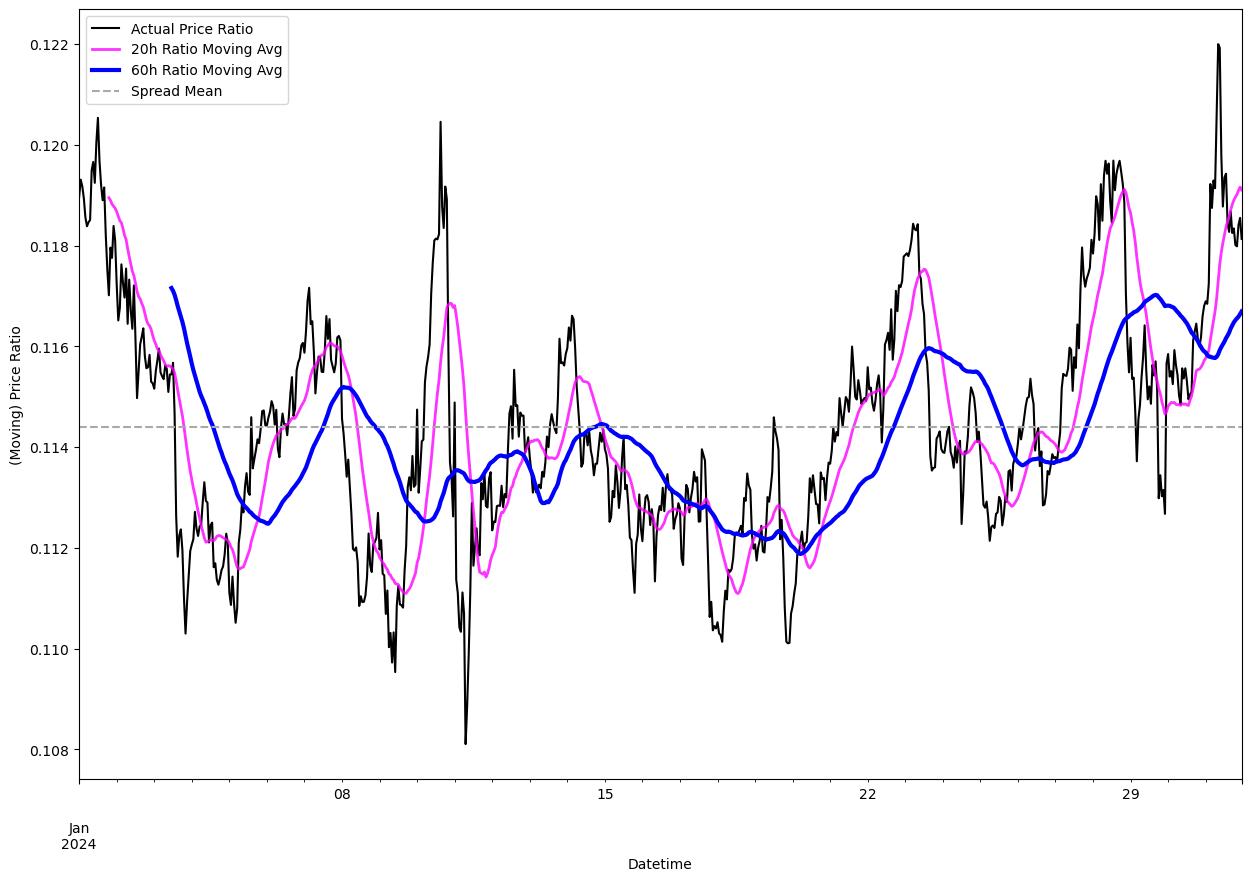

In [88]:
plt.figure(figsize=(15, 10))
price_ratio.plot(color = 'black')
PR_20D_MAVG.plot(color = 'magenta', linewidth=2, alpha = .8)
PR_60D_MAVG.plot(color = 'b', linewidth=3)
plt.axhline(price_ratio.mean(), color = 'darkgrey', linestyle = 'dashed' )
plt.legend(['Actual Price Ratio', '20h Ratio Moving Avg', '60h Ratio Moving Avg', 'Spread Mean'])
plt.ylabel('(Moving) Price Ratio')
plt.show()

<AxesSubplot:xlabel='Datetime'>

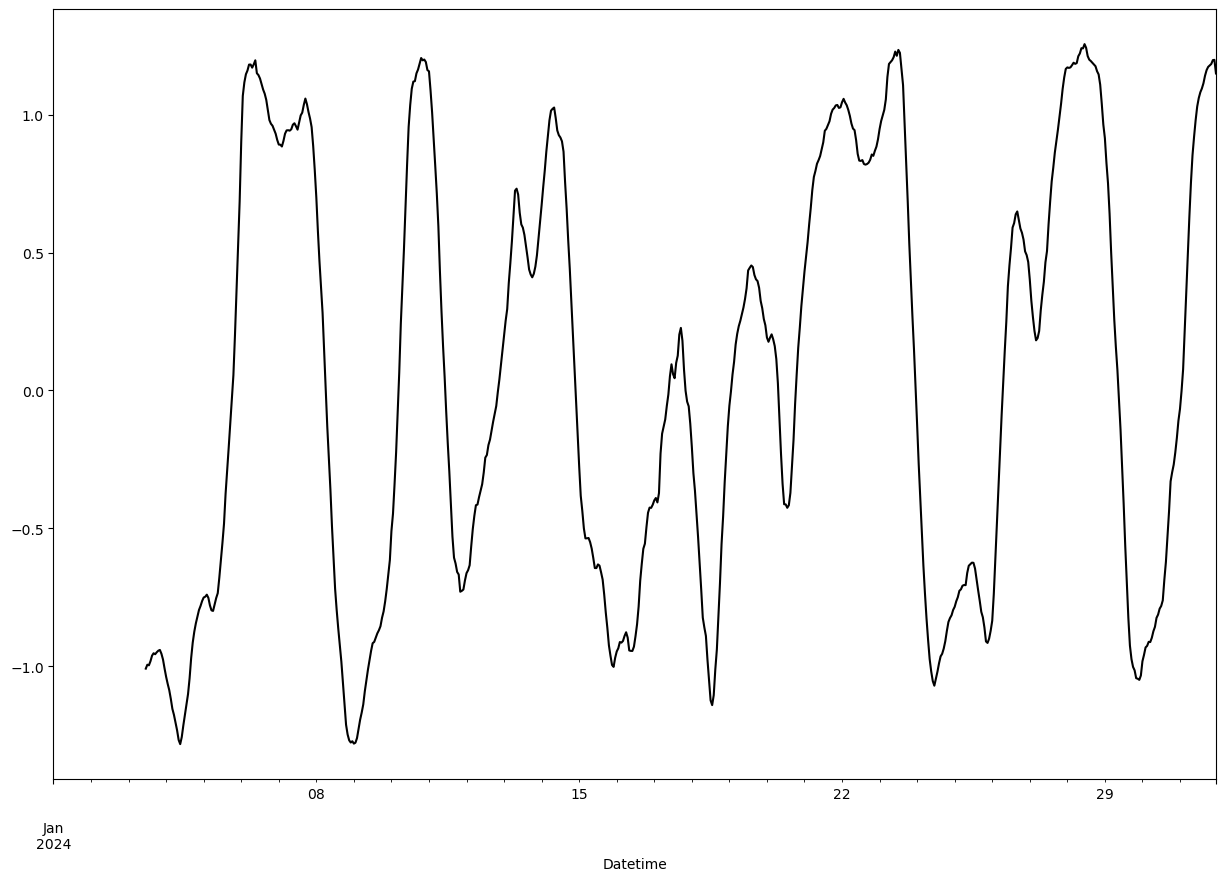

In [89]:
STD_60 = price_ratio.rolling(window=60).std()
Rolling_Z_Score = ((PR_20D_MAVG - PR_60D_MAVG)/STD_60)
Rolling_Z_Score.plot(figsize=(15,10), color = 'black')

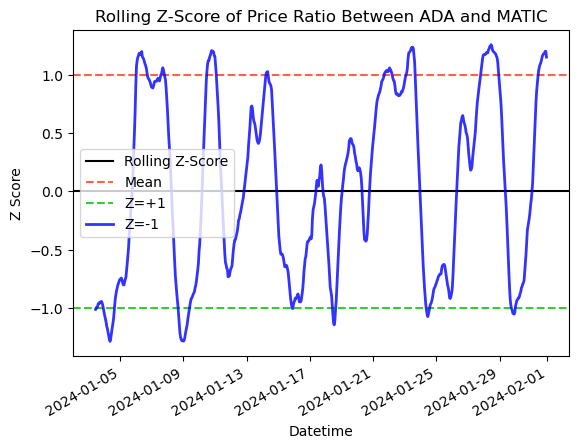

In [90]:
plt.axhline(0, color='black')
plt.axhline(1, color='tomato', linestyle='dashed')
plt.axhline(-1, color='limegreen', linestyle='dashed')
Rolling_Z_Score.plot(color = 'BLUE', linewidth=2, alpha = .8)
plt.legend(['Rolling Z-Score', 'Mean', 'Z=+1', 'Z=-1'])
plt.title("Rolling Z-Score of Price Ratio Between ADA and MATIC")
plt.ylabel('Z Score')
plt.show()

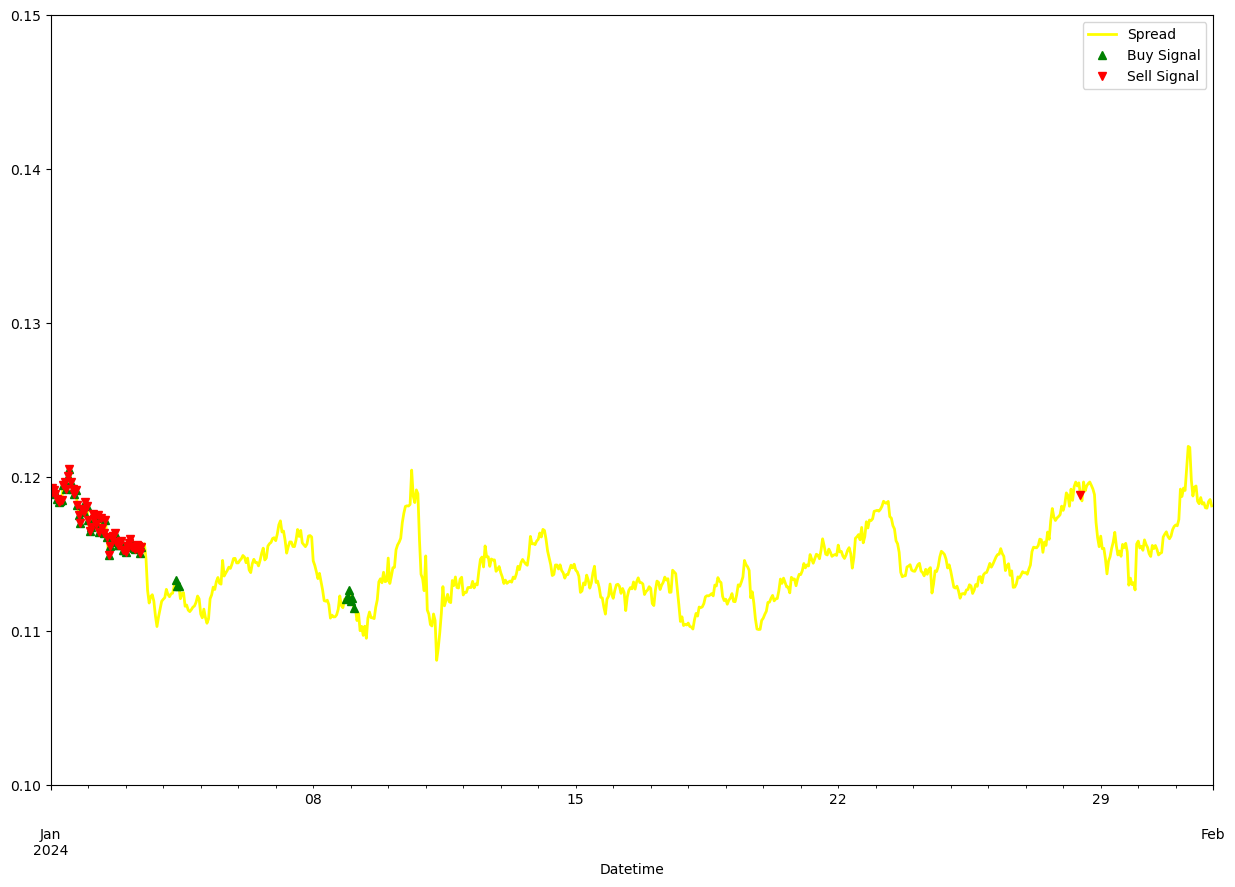

In [93]:
price_ratio.plot(figsize=(15,10), color = 'yellow', linewidth = 2)
buy  = price_ratio.copy()
sell = price_ratio.copy()


buy[Rolling_Z_Score > -1.25] = 0
buy.plot(color='g', linestyle='None', marker='^')


sell[Rolling_Z_Score < 1.25] = 0
sell.plot(color='r', linestyle='None', marker='v')


plt.axis(('2024-01-01', '2024-02-01',0.1,0.15))

plt.legend(['Spread', 'Buy Signal', 'Sell Signal'])
plt.show()